In [1]:
from warnings import filterwarnings

filterwarnings("ignore")
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from crypto_momentum_portfolios.utility.data_loader import CryptoDataLoaderQIL
from crypto_momentum_portfolios.utility.types import (
    DataFrequency,
    Fields,
    RebalanceFrequency,
    Side,
    RankingMode,
    AllocationMethod,
    RankingMethod,
    AllocationMode,
    Benchmark,
)
from crypto_momentum_portfolios.portfolio_management.benchmarks import (
    BenchmarkDataFrameBuilder,
)
from crypto_momentum_portfolios.portfolio_management.backtester import (
    PortfolioBacktester,
)

dl = CryptoDataLoaderQIL()  # CryptoDataLoader()
dl.assets

Loading BokehJS ...

Fetching symbols...: 100%|██████████| 21/21 [00:00<00:00, 59.83it/s]


['AVAX-USDT',
 'XTZ-USDT',
 'BNB-USDT',
 'ETC-USDT',
 'BCH-USDT',
 'DOGE-USDT',
 'SOL-USDT',
 'ADA-USDT',
 'DASH-USDT',
 'ATOM-USDT',
 'TRX-USDT',
 'VET-USDT',
 'LTC-USDT',
 'MATIC-USDT',
 'BTC-USDT',
 'EOS-USDT',
 'XLM-USDT',
 'LINK-USDT',
 'ETH-USDT',
 'XRP-USDT',
 'KDA-USDT']

In [2]:
MOMENTUM_LOOKBACK = 30
universe = (
    dl.get_crypto(
        "all",
        data_frequency=DataFrequency.DAILY,
        fields=[
            Fields.PRICE,
            Fields.MARKET_CAP,
            Fields.MOMENTUM,
            Fields.EMA_MOMENTUM,
            Fields.TS_MOMENTUM,
            Fields.VOLATILITY_NEUTRALIZED_MOMENTUM,
            Fields.RETURNS,
            Fields.VOLATILITY,
            Fields.VOLUME,
        ],
        flatten_fields_with_crypto=False,
        momentum_lookback=MOMENTUM_LOOKBACK,
    )
    .dropna()
    .loc["2021-11-28":]  # "2021-10-28"
)
universe.head()

price                                                         \
           AVAX-USDT XTZ-USDT BNB-USDT ETC-USDT BCH-USDT DOGE-USDT SOL-USDT   
Date                                                                          
2021-11-28   110.575  4.64191  611.532  47.4672   568.80   0.20770  200.770   
2021-11-29   120.482  5.61405  623.640  48.1875   574.83   0.21494  204.070   
2021-11-30   120.424  5.47899  622.242  48.2260   569.70   0.21466  208.286   
2021-12-01   119.708  5.23289  627.628  47.8143   570.69   0.20929  229.740   
2021-12-02   108.500  5.08153  619.959  47.0044   561.47   0.20955  233.679   

                                          ...        volume                \
            ADA-USDT DASH-USDT ATOM-USDT  ...      VET-USDT      LTC-USDT   
Date                                      ...                               
2021-11-28  1.595524    178.47   27.3897  ...  2.177937e+07  3.164576e+07   
2021-11-29  1.601726    182.01   28.0818  ...  1.840140e+07  2.372944e+07   
2021-11-30  1.553406    179.95   27.5238  ...  2.446765e+07  3.569569e+07   
2021-12-01  1.546680    178.17   26.6392  ...  2.007644e+07  2.511659e+07   
2021-12-02  1.719545    176.11   28.3657  ...  1.347376e+07  2.276300e+07   

                                                                    \
              MATIC-USDT      BTC-USDT      EOS-USDT      XLM-USDT   
Date                                                                 
2021-11-28  1.765200e+07  3.711303e+08  8.129372e+06  1.085601e+07   
2021-11-29  2.359213e+07  4.083367e+08  6.621522e+06  9.490191e+06   
2021-11-30  3.462481e+07  4.683648e+08  9.964520e+06  1.485177e+07   
2021-12-01  6.781443e+07  4.177976e+08  6.266806e+06  1.150287e+07   
2021-12-02  1.130235e+08  3.376922e+08  5.472080e+06  1.362993e+07   

                                                                    
               LINK-USDT      ETH-USDT      XRP-USDT      KDA-USDT  
Date                                                                
2021-11-28  1.059746e+07  3.233202e+08  7.165532e+07  4.321501e+07  
2021-11-29  1.140279e+07  2.890552e+08  6.614817e+07  3.435264e+07  
2021-11-30  1.565956e+07  5.012545e+08  8.494273e+07  4.014490e+07  
2021-12-01  1.452881e+07  3.540249e+08  5.752341e+07  4.504407e+07  
2021-12-02  7.816724e+06  3.665087e+08  5.429675e+07  2.883999e+07  

[5 rows x 189 columns]

Weight drift :

$$w_i^k=\frac{w_{i-1}^k\times (1+r_i^k)}{\sum_{j=1}^n w_{i-1}^j\times(1+r_i^j)}$$

For asset $k$ at time $i$ given $n$ asset in the portfolio.


# Building a benchmark


## Capitalization weighted index


In [3]:
benchmarks = (
    BenchmarkDataFrameBuilder(universe)
    .build_equally_weighted_benchmark(
        rebalance_frequency=RebalanceFrequency.MONTHLY, side=Side.LONG, verbose=False
    )
    .build_capitalization_weighted_benchmark(
        capitalization_field=Fields.MARKET_CAP,
        rebalance_frequency=RebalanceFrequency.MONTHLY,
        side=Side.LONG,
        verbose=False,
    )
    .build_bitcoin_benchmark()
    .collect_benchmark_returns()
)
benchmarks

,equal_weighted_benchmark,capi_weighted_benchmark,bitcoin_benchmark
Date,,,
2021-11-28,-0.003276,0.013729,0.046803
2021-11-29,0.032969,0.023788,0.008763
2021-11-30,-0.023637,-0.013165,-0.014700
2021-12-01,0.004637,0.002385,0.004557
2021-12-02,-0.002240,-0.011346,-0.012291
...,...,...,...
2023-12-31,-0.027769,-0.021316,0.003127
2024-01-01,0.043029,0.045546,0.044894
2024-01-02,-0.020277,-0.004449,0.017326


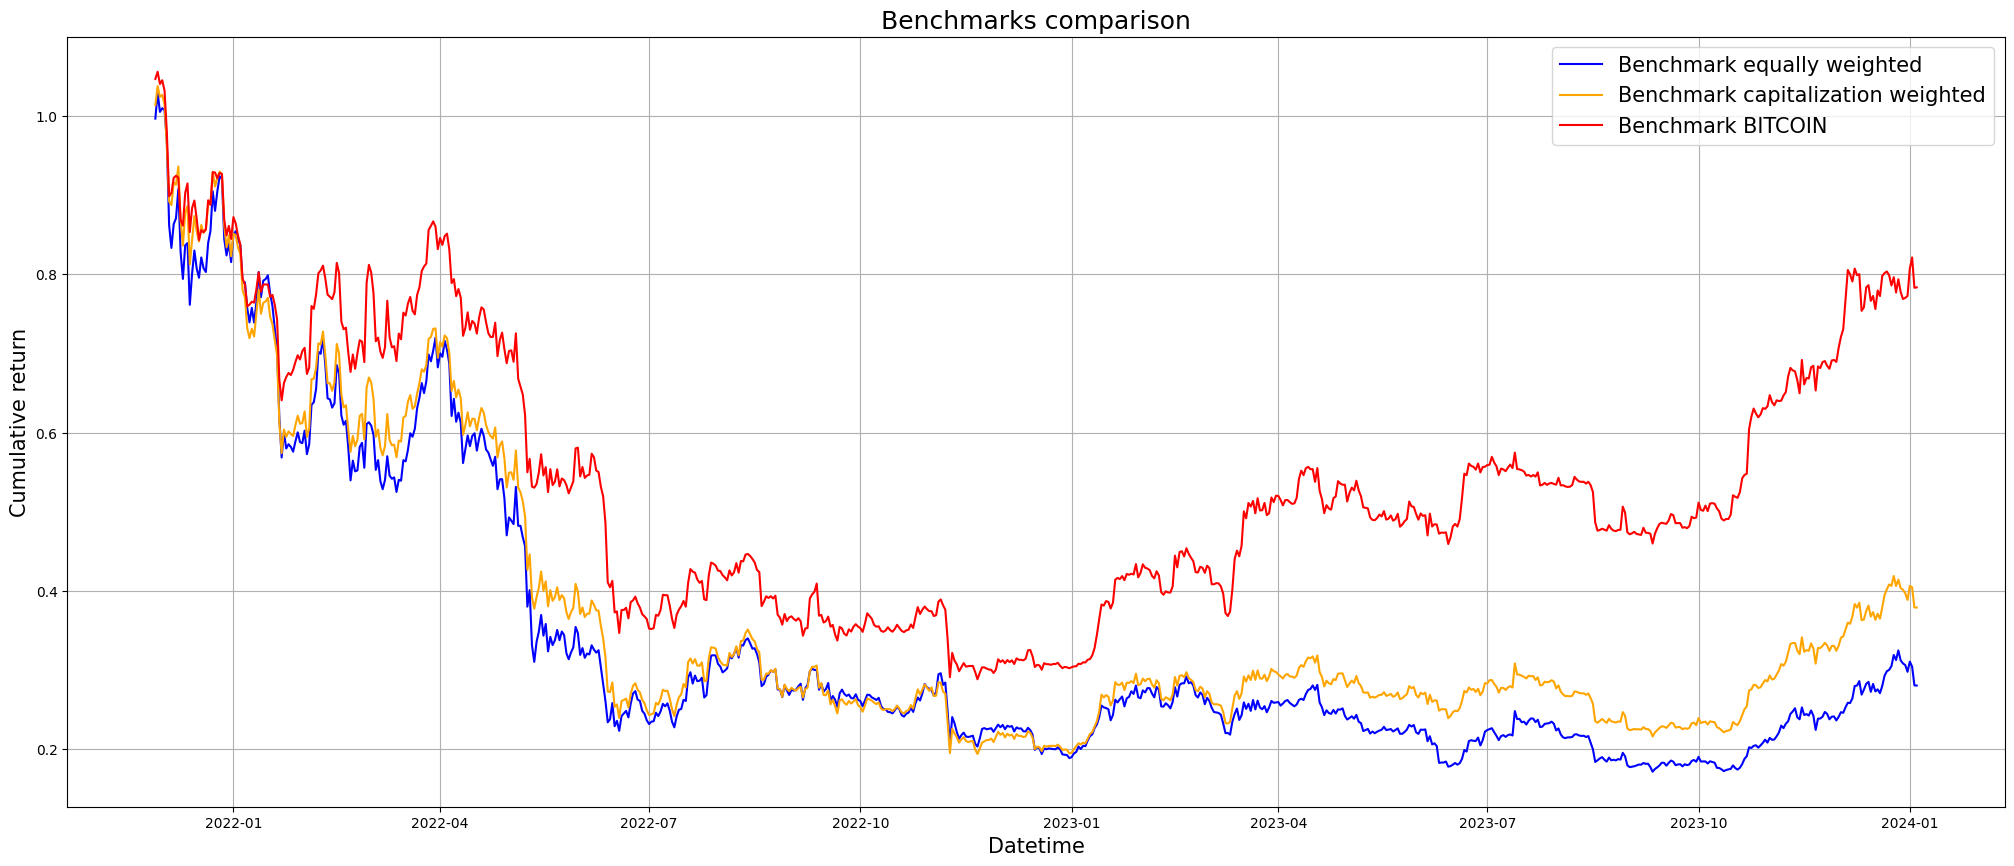

In [4]:
f, ax = plt.subplots(1, 1, figsize=(25, 10))
ax.set_title("Benchmarks comparison", fontsize=18)
ax.grid()
ax.plot(
    (benchmarks["equal_weighted_benchmark"] + 1).cumprod(),
    label="Benchmark equally weighted",
    color="blue",
)
ax.plot(
    (benchmarks["capi_weighted_benchmark"] + 1).cumprod(),
    label="Benchmark capitalization weighted",
    color="orange",
)
ax.plot(
    (benchmarks["bitcoin_benchmark"] + 1).cumprod(),
    label="Benchmark BITCOIN",
    color="red",
)


ax.set_xlabel("Datetime", fontsize=15)
ax.set_ylabel("Cumulative return", fontsize=15)
ax.legend(loc="upper right", fontsize=15)
# ax.set_yscale("log")

# Backtesting strategies


## Backtesting with a benchmark and a strategy


In [5]:
ptf_backtester = PortfolioBacktester(universe=universe,)

returns_capi, _ = ptf_backtester.run_strategy(
    ranking_method=RankingMethod.MOMENTUM,
    ranking_mode=RankingMode.DESCENDING,
    select_top_k_assets=5,
    allocation_method=AllocationMethod.MOMENTUM_WEIGHTED,
    allocation_mode=AllocationMode.CLASSIC,
    rebalance_frequency=RebalanceFrequency.MONTHLY,
    side=Side.LONG,
    benchmark=Benchmark.CAPITALIZATION_WEIGHTED,
    verbose=False,
    print_stats=True,
    plot_curve=True,
    perform_t_stats=True
)


-----------------Expected return------------------
Benchmark: -25.84% vs Strategy: 3.47%

t-stat: 5.69, p-value: 0.00
Statistically different from the bench

-----------------------CAGR-----------------------
Benchmark: -37.34% vs Strategy: -40.35%

t-stat: 6.82, p-value: 0.00
Statistically different from the bench

---------------Expected volatility----------------
Benchmark: 63.31% vs Strategy: 105.11%

t-stat: 83.74, p-value: 0.00
Statistically different from the bench

---------------------Skewness---------------------
Benchmark: -0.31 vs Strategy: 0.56

t-stat: 16.30, p-value: 0.00
Statistically different from the bench

---------------------Kurtosis---------------------
Benchmark: 3.16 vs Strategy: 10.34

t-stat: 24.91, p-value: 0.00
Statistically different from the bench

-----------------------VaR------------------------
Benchmark: -5.56% vs Strategy: -7.92%

t-stat: -44.11, p-value: 0.00
Statistically different from the bench

-----------------------CVaR----------------------

Loading BokehJS ...

Loading BokehJS ...

## Several strategies


In [6]:
ptf_backtester = PortfolioBacktester(universe=universe)

returns_capi, _ = ptf_backtester.run_strategy(
    allocation_method=AllocationMethod.CAPITALIZATION_WEIGHTED,
    rebalance_frequency=RebalanceFrequency.MONTHLY,
    side=Side.LONG,
    verbose=False,
    print_stats=False,
    plot_curve=False,
)
returns_capi.name = "capitalization_weighted"

returns_rp, _ = ptf_backtester.run_strategy(
    allocation_method=AllocationMethod.RISK_PARITY,
    rebalance_frequency=RebalanceFrequency.MONTHLY,
    side=Side.LONG,
    verbose=False,
    print_stats=False,
    plot_curve=False,
)
returns_rp.name = "risk_parity"
returns_mv, _ = ptf_backtester.run_strategy(
    allocation_method=AllocationMethod.MEAN_VARIANCE,
    rebalance_frequency=RebalanceFrequency.MONTHLY,
    side=Side.LONG,
    verbose=False,
    print_stats=False,
    plot_curve=False,
)
returns_mv.name = "mean_variance"
returns, weights_df = ptf_backtester.run_strategy(
    allocation_method=AllocationMethod.EQUAL_WEIGHTED,
    rebalance_frequency=RebalanceFrequency.MONTHLY,
    side=Side.LONG,
    verbose=False,
    print_stats=False,
    plot_curve=False,
)
returns.name = "equal_weighted"

In [7]:
returns_df = pd.concat([returns, returns_capi, returns_rp, returns_mv], axis=1)
returns_df

,equal_weighted,capitalization_weighted,risk_parity,mean_variance
Date,,,,
2021-11-28,0.011584,0.027229,0.011584,0.011584
2021-11-29,0.042065,0.036642,0.042065,0.042065
2021-11-30,0.003932,0.024262,0.004147,0.031965
2021-12-01,0.024791,0.001459,0.026204,-0.009614
2021-12-02,-0.026991,-0.021965,-0.024709,-0.023110
...,...,...,...,...
2023-12-31,-0.017187,-0.006793,-0.015267,-0.015301
2024-01-01,0.038654,0.044952,0.034651,0.032252
2024-01-02,-0.010777,0.001970,-0.006111,-0.010702


### Plot all strategies


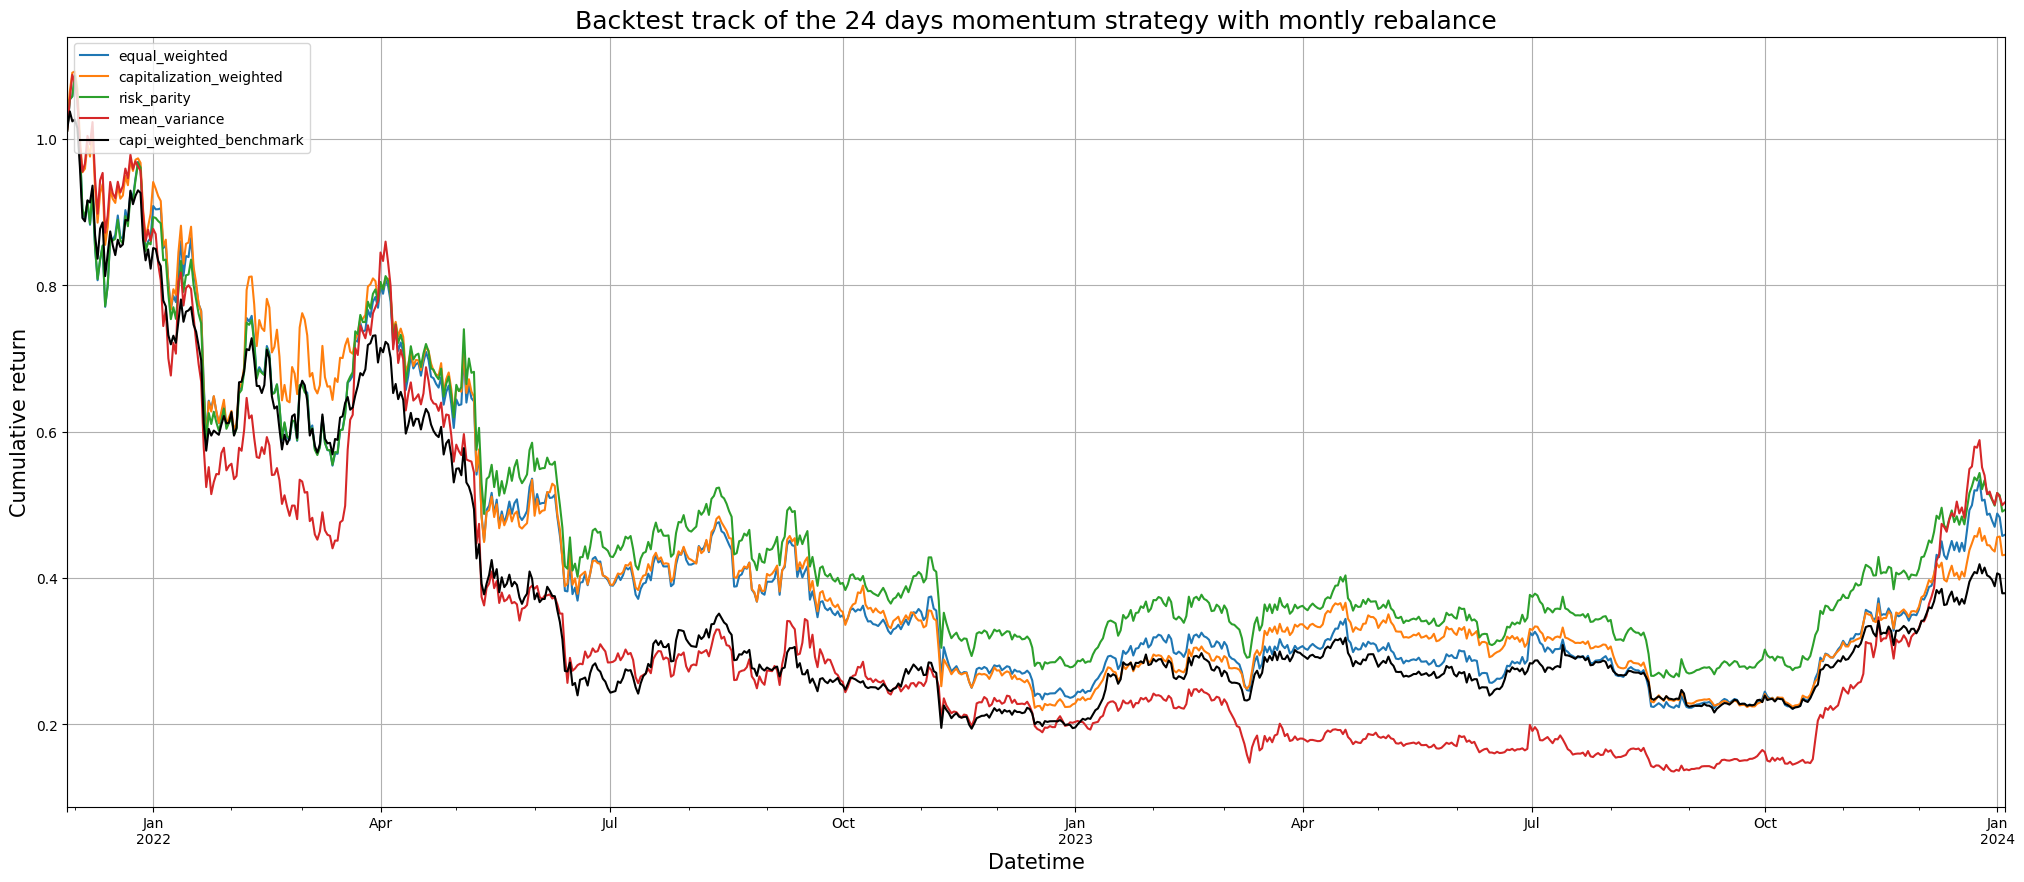

In [8]:
ax = (returns_df + 1).cumprod().plot(figsize=(25, 10), grid=True)

ax.set_title(
    "Backtest track of the 24 days momentum strategy with montly rebalance", fontsize=18
)

ax.plot(
    (benchmarks["capi_weighted_benchmark"] + 1).cumprod(),
    label="capi_weighted_benchmark",
    color="black",
)
ax.set_xlabel("Datetime", fontsize=15)
ax.set_ylabel("Cumulative return", fontsize=15)
ax.legend(loc="upper left")
# ax.set_yscale("log")

### Plot one strategy


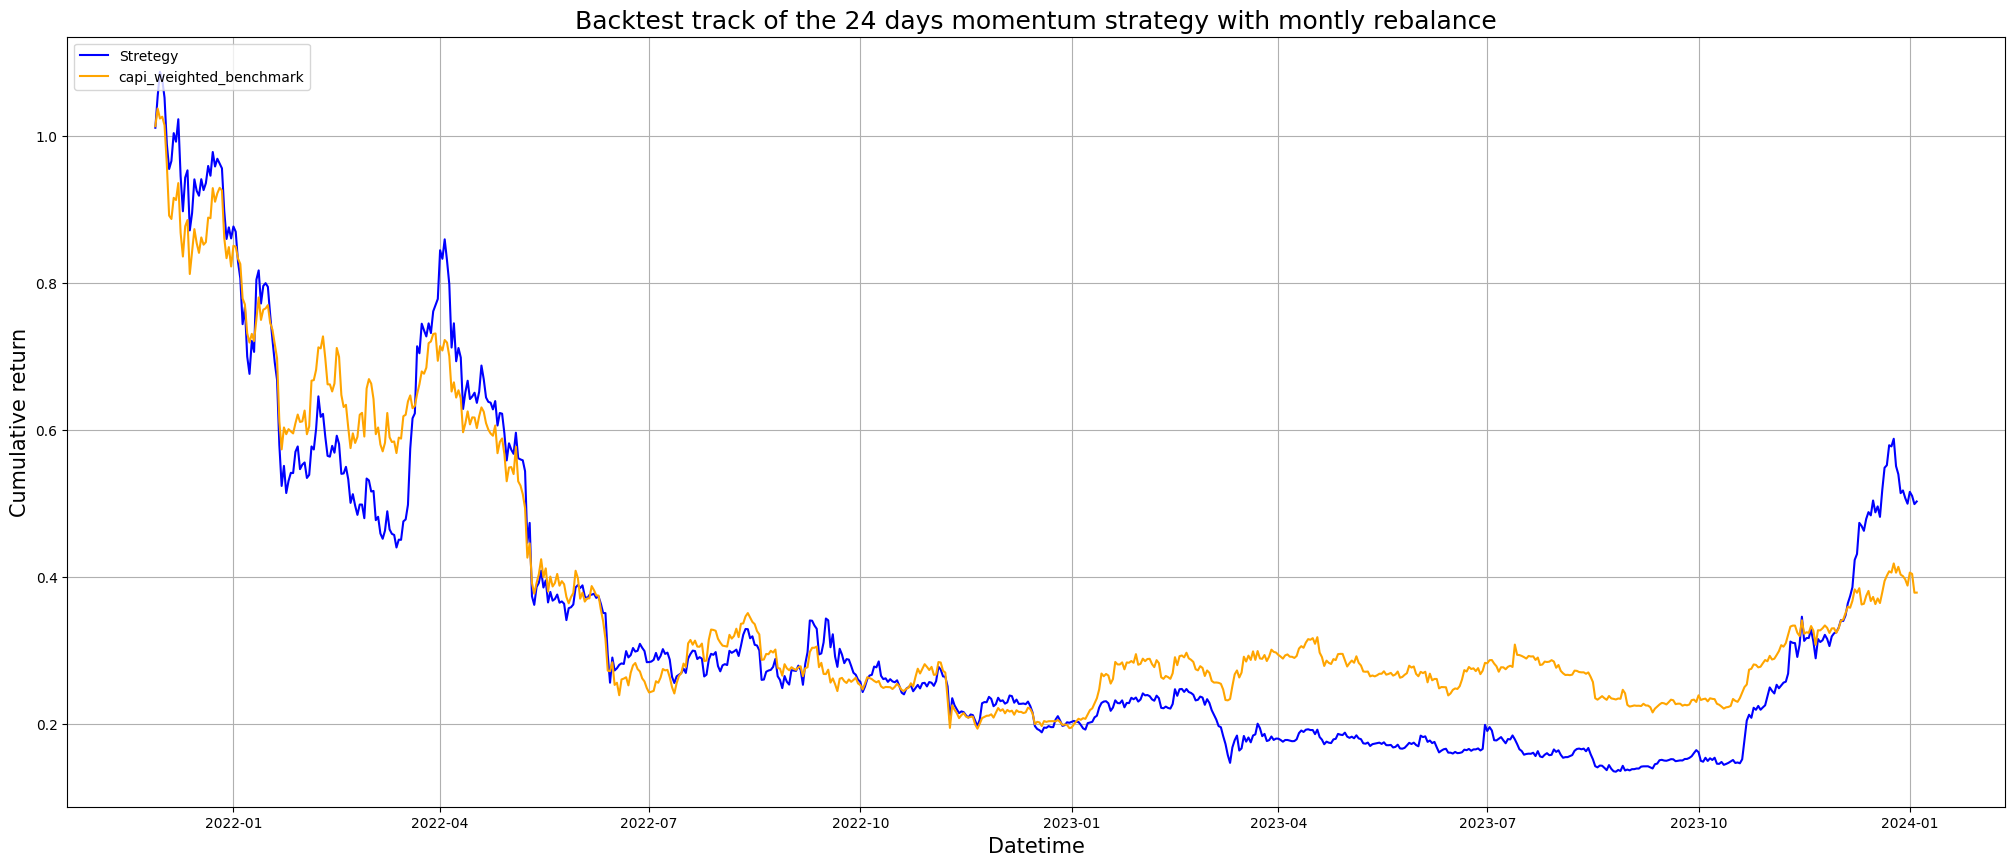

In [9]:
f, ax = plt.subplots(1, 1, figsize=(25, 10))

ax.set_title(
    "Backtest track of the 24 days momentum strategy with montly rebalance", fontsize=18
)
ax.plot(
    (returns_df["mean_variance"] + 1).cumprod(),
    label="Stretegy",
    color="blue",
)

ax.plot(
    (benchmarks["capi_weighted_benchmark"] + 1).cumprod(),
    label="capi_weighted_benchmark",
    color="orange",
)
ax.set_xlabel("Datetime", fontsize=15)
ax.set_ylabel("Cumulative return", fontsize=15)
ax.legend(loc="upper left")
# ax.set_yscale("log")

ax.grid()

## Weights analysis


In [10]:
weights_df

,ETH-USDT,BNB-USDT,AVAX-USDT,KDA-USDT,MATIC-USDT,SOL-USDT,ATOM-USDT,TRX-USDT,VET-USDT,DOGE-USDT,XLM-USDT,XRP-USDT,BTC-USDT,BCH-USDT,ETC-USDT,ADA-USDT,EOS-USDT,LINK-USDT,LTC-USDT,DASH-USDT
Date,,,,,,,,,,,,,,,,,,,,
2021-11-28,0.200000,0.200000,0.200000,0.200000,0.200000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2021-11-29,0.206258,0.200432,0.191500,0.200241,0.201568,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2021-11-30,0.200000,0.200000,0.200000,0.200000,0.000000,0.200000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2021-12-01,0.206381,0.197687,0.198036,0.195672,0.000000,0.202225,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2021-12-02,0.199374,0.194575,0.192096,0.196297,0.000000,0.217658,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31,0.200000,0.200000,0.000000,0.000000,0.000000,0.200000,0.0,0.0,0.0,0.0,0.0,0.0,0.200000,0.200000,0.0,0.0,0.0,0.0,0.0,0.0
2024-01-01,0.201553,0.199183,0.000000,0.000000,0.000000,0.202025,0.0,0.0,0.0,0.0,0.0,0.0,0.202998,0.194241,0.0,0.0,0.0,0.0,0.0,0.0
2024-01-02,0.199948,0.192749,0.000000,0.000000,0.000000,0.210246,0.0,0.0,0.0,0.0,0.0,0.0,0.204217,0.192839,0.0,0.0,0.0,0.0,0.0,0.0
